# Neural network based integrator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from dynamical_system import *
from time_integrator import *

np.random.seed(2512517)

## Neural network integrator
This class is used to implement a neural network based integrator with a $S$-step method. This is integrating a given $d$-dimensional system $\frac{dq(t)}{dt}=\mathcal{N}(q(t))$. Here $q(t)=(x(t),v(t))\in\mathbb{R}^{2d}$ is the state vector. The underlying neural model implements the mapping

$$
q^{(t-(S-1)\Delta t)},\dots,q^{(t-\Delta t)},q^{(t)} \mapsto q^{(t+\Delta t)}
$$

Internally this is realised by mapping the $B\times S \times d$ tensor $X$ to the $B\times d$ tensor $y$, where $B$ is the minibatch-size.

In [2]:
class NNIntegrator(object):
    def __init__(self,dynamical_system,nsteps,dt):
        self.dynamical_system = dynamical_system
        self.dt = dt
        self.nsteps = nsteps
        self.dim = 2*self.dynamical_system.dim
        self.model = tf.keras.Sequential([keras.layers.InputLayer(input_shape=(self.nsteps,self.dim)),
                                          keras.layers.Dense(16,activation='sigmoid'),
                                          keras.layers.Dense(32,activation='sigmoid'),
                                          keras.layers.Dense(16,activation='sigmoid'),
                                          keras.layers.Flatten(),
                                          keras.layers.Dense(self.dim)])
        self.model.compile(loss='mse',metrics=[],optimizer=keras.optimizers.Adam())
        self.xv = np.zeros((1,self.nsteps,self.dim))

    def set_state(self,x,v):
        '''Set the current state of the integrator
        
        :arg x: Array of size nsteps x dim with initial positions
        :arg v: Array of size nsteps x dim with initial velocities
        '''
        self.xv[0,:,:self.dim//2] = x[:,:]
        self.xv[0,:,self.dim//2:] = v[:,:]
        
    @property
    def x(self):
        '''Return the current position vector (as a d-dimensional array)'''
        return self.xv[0,-1,:self.dim//2]

    @property
    def v(self):
        '''Return the current velocity vector (as a d-dimensional array)'''
        return self.xv[0,-1,self.dim//2:]
    
    def integrate(self,n_steps):
        '''Carry out a given number of integration steps
        
        :arg n_steps: number of integration steps
        '''
        for k in range(n_steps):
            x_pred = np.asarray(self.model.predict(self.xv)).flatten()
            self.xv = np.roll(self.xv, -1, axis=1)
            self.xv[0,-1,:] = x_pred[:]
            

Set system parameters, construct dynamical system and integrator.

The model system we are using here is the harmonic oscillator, defined by the equations of motion

$$
\frac{dx}{dt} = v,\qquad\qquad
\frac{dv}{dt} = -\frac{k}{m}x
$$

The timestep size of the Neural network integrator is set to $\Delta t=10\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3, 16)             48        
_________________________________________________________________
dense_1 (Dense)              (None, 3, 32)             544       
_________________________________________________________________
dense_2 (Dense)              (None, 3, 16)             528       
_________________________________________________________________
flatten (Flatten)            (None, 48)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 98        
Total params: 1,218
Trainable params: 1,218
Non-trainable params: 0
_________________________________________________________________


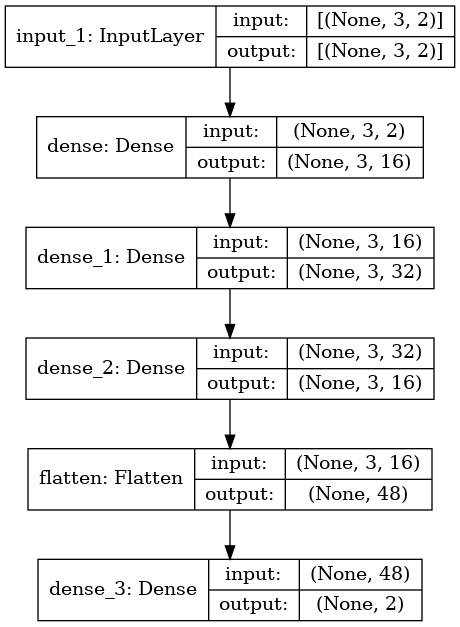

In [3]:
mass = 1.2
k_spring = 0.9
dt_verlet = 0.01
dt = 0.1
nsteps = 3
harmonic_oscillator = HarmonicOscillator(mass,k_spring)
verlet_integrator = VerletIntegrator(harmonic_oscillator,dt_verlet)
nn_integrator = NNIntegrator(harmonic_oscillator,nsteps,dt)

nn_integrator.model.summary()
keras.utils.plot_model(nn_integrator.model, show_shapes=True)

The following data generator class can be used to construct training data samples of the form $(X_j,y_j)$ where

$$
X_j = q_j^{(0)},q_j^{(\Delta t)},\dots,q_j^{(t+(S-1)\Delta t)},\qquad\qquad y_j = q_j^{(t+S\Delta t)}.
$$

Here $q_j^{(0)}$ is a randomly chosen initial condition and the states $q_j^{(\Delta t)},\dots,q_j^{(t+(S-1)\Delta t)}, q_j^{(t+S\Delta t)}$ are generated with a training generator that is run with a smaller timestep.

In [4]:
class DataGenerator(object):
    def __init__(self,nn_integrator,train_integrator):        
        self.nn_integrator = nn_integrator
        self.train_integrator = train_integrator
        self.dynamical_system = self.nn_integrator.dynamical_system
        self.dataset = tf.data.Dataset.from_generator(self._generator,                                                      
                                                      output_signature=(
                                                          tf.TensorSpec(shape=(self.nn_integrator.nsteps,
                                                                               2*self.dynamical_system.dim), dtype=tf.float32),
                                                          tf.TensorSpec(shape=(2*self.dynamical_system.dim), dtype=tf.float32)
                                                      ))
    
    def _generator(self):
        state = np.zeros((self.nn_integrator.nsteps+1,2*self.dynamical_system.dim))
        while True:
            self.dynamical_system.set_random_state(state[0,:self.dynamical_system.dim],
                                                   state[0,self.dynamical_system.dim:])
            self.train_integrator.set_state(state[0,:self.dynamical_system.dim],
                                            state[0,self.dynamical_system.dim:])
            for k in range(self.nn_integrator.nsteps):
                self.train_integrator.integrate(int(self.nn_integrator.dt/self.train_integrator.dt))
                state[k+1,:self.dynamical_system.dim] = self.train_integrator.x[:]
                state[k+1,self.dynamical_system.dim:] = self.train_integrator.v[:]
            X = state[:-1,:]
            y = state[-1,:]
            yield (X,y)
    
BATCH_SIZE=32
data_generator = DataGenerator(nn_integrator,verlet_integrator)
train_batches = data_generator.dataset.batch(BATCH_SIZE)

## Train neural network based integrator

Note that training history can be visualised with tensorboard:

```
tensorboard --logdir=./tb_logs
```

In [5]:
EPOCHS=1500
STEPS_PER_EPOCH=100
log_dir = './tb_logs/'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result = nn_integrator.model.fit(train_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)

Epoch 1/1500
100/100 [==============================] - 2s 19ms/step - loss: 1.0892
Epoch 2/1500
100/100 [==============================] - 2s 17ms/step - loss: 0.9275
Epoch 3/1500
100/100 [==============================] - 2s 17ms/step - loss: 0.7682
Epoch 4/1500
100/100 [==============================] - 2s 17ms/step - loss: 0.4281
Epoch 5/1500
100/100 [==============================] - 2s 16ms/step - loss: 0.1668
Epoch 6/1500
100/100 [==============================] - 2s 16ms/step - loss: 0.0464
Epoch 7/1500
100/100 [==============================] - 2s 16ms/step - loss: 0.0390
Epoch 8/1500
100/100 [==============================] - 2s 16ms/step - loss: 0.0350
Epoch 9/1500
100/100 [==============================] - 2s 16ms/step - loss: 0.0297
Epoch 10/1500
100/100 [==============================] - 2s 16ms/step - loss: 0.0285
Epoch 11/1500
100/100 [==============================] - 2s 16ms/step - loss: 0.0285
Epoch 12/1500
100/100 [==============================] - 2s 16ms/step - lo

100/100 [==============================] - 2s 16ms/step - loss: 0.0010
Epoch 98/1500
100/100 [==============================] - 2s 15ms/step - loss: 7.4736e-04
Epoch 99/1500
100/100 [==============================] - 2s 16ms/step - loss: 9.8386e-04
Epoch 100/1500
100/100 [==============================] - 2s 15ms/step - loss: 0.0011
Epoch 101/1500
100/100 [==============================] - 1s 15ms/step - loss: 9.5885e-04
Epoch 102/1500
100/100 [==============================] - 2s 15ms/step - loss: 8.0651e-04
Epoch 103/1500
100/100 [==============================] - 2s 16ms/step - loss: 8.5273e-04
Epoch 104/1500
100/100 [==============================] - 2s 16ms/step - loss: 0.0011
Epoch 105/1500
100/100 [==============================] - 2s 16ms/step - loss: 9.3132e-04
Epoch 106/1500
100/100 [==============================] - 2s 16ms/step - loss: 7.4681e-04
Epoch 107/1500
100/100 [==============================] - 1s 15ms/step - loss: 9.2396e-04
Epoch 108/1500
100/100 [===============

100/100 [==============================] - 1s 14ms/step - loss: 5.8595e-04
Epoch 189/1500
100/100 [==============================] - 2s 15ms/step - loss: 4.9624e-04
Epoch 190/1500
100/100 [==============================] - 2s 16ms/step - loss: 5.2582e-04
Epoch 191/1500
100/100 [==============================] - 2s 16ms/step - loss: 4.3977e-04
Epoch 192/1500
100/100 [==============================] - 2s 16ms/step - loss: 5.3419e-04
Epoch 193/1500
100/100 [==============================] - 2s 16ms/step - loss: 6.3421e-04
Epoch 194/1500
100/100 [==============================] - 2s 16ms/step - loss: 4.1034e-04
Epoch 195/1500
100/100 [==============================] - 2s 15ms/step - loss: 5.5987e-04
Epoch 196/1500
100/100 [==============================] - 2s 16ms/step - loss: 4.5395e-04
Epoch 197/1500
100/100 [==============================] - 2s 15ms/step - loss: 5.8138e-04
Epoch 198/1500
100/100 [==============================] - 2s 16ms/step - loss: 5.4613e-04
Epoch 199/1500
100/100 [=

100/100 [==============================] - 2s 17ms/step - loss: 5.1418e-04
Epoch 280/1500
100/100 [==============================] - 2s 17ms/step - loss: 3.2174e-04
Epoch 281/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.9660e-04
Epoch 282/1500
100/100 [==============================] - 2s 17ms/step - loss: 3.2595e-04
Epoch 283/1500
100/100 [==============================] - 2s 16ms/step - loss: 4.2129e-04
Epoch 284/1500
100/100 [==============================] - 2s 17ms/step - loss: 4.3194e-04
Epoch 285/1500
100/100 [==============================] - 2s 17ms/step - loss: 3.6641e-04
Epoch 286/1500
100/100 [==============================] - 2s 16ms/step - loss: 3.4273e-04
Epoch 287/1500
100/100 [==============================] - 2s 17ms/step - loss: 4.1697e-04
Epoch 288/1500
100/100 [==============================] - 2s 17ms/step - loss: 2.5727e-04
Epoch 289/1500
100/100 [==============================] - 2s 16ms/step - loss: 4.2850e-04
Epoch 290/1500
100/100 [=

100/100 [==============================] - 2s 16ms/step - loss: 2.8503e-04
Epoch 371/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.8191e-04
Epoch 372/1500
100/100 [==============================] - 2s 16ms/step - loss: 3.3497e-04
Epoch 373/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.5753e-04
Epoch 374/1500
100/100 [==============================] - 1s 14ms/step - loss: 3.0671e-04
Epoch 375/1500
100/100 [==============================] - 2s 16ms/step - loss: 3.7525e-04
Epoch 376/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.6616e-04
Epoch 377/1500
100/100 [==============================] - 2s 15ms/step - loss: 2.7848e-04
Epoch 378/1500
100/100 [==============================] - 2s 15ms/step - loss: 2.9302e-04
Epoch 379/1500
100/100 [==============================] - 1s 15ms/step - loss: 2.6491e-04
Epoch 380/1500
100/100 [==============================] - 1s 15ms/step - loss: 3.6171e-04
Epoch 381/1500
100/100 [=

100/100 [==============================] - 2s 16ms/step - loss: 2.4574e-04
Epoch 462/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.2428e-04
Epoch 463/1500
100/100 [==============================] - 2s 17ms/step - loss: 2.2037e-04
Epoch 464/1500
100/100 [==============================] - 2s 17ms/step - loss: 2.1208e-04
Epoch 465/1500
100/100 [==============================] - 2s 17ms/step - loss: 2.5691e-04
Epoch 466/1500
100/100 [==============================] - 2s 17ms/step - loss: 1.9883e-04
Epoch 467/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.3689e-04
Epoch 468/1500
100/100 [==============================] - 1s 15ms/step - loss: 2.5827e-04
Epoch 469/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.9945e-04
Epoch 470/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.2076e-04
Epoch 471/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.1045e-04
Epoch 472/1500
100/100 [=

100/100 [==============================] - 2s 17ms/step - loss: 2.4267e-04
Epoch 553/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.4621e-04
Epoch 554/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.0122e-04
Epoch 555/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.4818e-04
Epoch 556/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.2011e-04
Epoch 557/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.8869e-04
Epoch 558/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.8471e-04
Epoch 559/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.5239e-04
Epoch 560/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.1356e-04
Epoch 561/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.2956e-04
Epoch 562/1500
100/100 [==============================] - 2s 17ms/step - loss: 1.3606e-04
Epoch 563/1500
100/100 [=

100/100 [==============================] - 2s 16ms/step - loss: 1.1700e-04
Epoch 644/1500
100/100 [==============================] - 2s 15ms/step - loss: 1.1381e-04
Epoch 645/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.3276e-04
Epoch 646/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.2012e-04
Epoch 647/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.2768e-04
Epoch 648/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.2830e-04
Epoch 649/1500
100/100 [==============================] - 2s 17ms/step - loss: 1.4263e-04
Epoch 650/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.2569e-04
Epoch 651/1500
100/100 [==============================] - 2s 15ms/step - loss: 1.1274e-04
Epoch 652/1500
100/100 [==============================] - 2s 16ms/step - loss: 9.4733e-05
Epoch 653/1500
100/100 [==============================] - 2s 16ms/step - loss: 9.6483e-05
Epoch 654/1500
100/100 [=

100/100 [==============================] - 2s 16ms/step - loss: 6.6521e-05
Epoch 735/1500
100/100 [==============================] - 2s 16ms/step - loss: 4.0333e-05
Epoch 736/1500
100/100 [==============================] - 2s 16ms/step - loss: 4.1950e-05
Epoch 737/1500
100/100 [==============================] - 2s 16ms/step - loss: 4.5840e-05
Epoch 738/1500
100/100 [==============================] - 2s 15ms/step - loss: 5.3582e-05
Epoch 739/1500
100/100 [==============================] - 1s 14ms/step - loss: 5.3578e-05
Epoch 740/1500
100/100 [==============================] - 1s 14ms/step - loss: 4.7894e-05
Epoch 741/1500
100/100 [==============================] - 2s 16ms/step - loss: 3.5214e-05
Epoch 742/1500
100/100 [==============================] - 2s 16ms/step - loss: 3.8775e-05
Epoch 743/1500
100/100 [==============================] - 2s 16ms/step - loss: 5.3737e-05
Epoch 744/1500
100/100 [==============================] - 2s 16ms/step - loss: 5.2370e-05
Epoch 745/1500
100/100 [=

100/100 [==============================] - 2s 17ms/step - loss: 1.4051e-05
Epoch 826/1500
100/100 [==============================] - 2s 17ms/step - loss: 1.8163e-05
Epoch 827/1500
100/100 [==============================] - 2s 16ms/step - loss: 4.3332e-05
Epoch 828/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.9181e-05
Epoch 829/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.1609e-05
Epoch 830/1500
100/100 [==============================] - 2s 17ms/step - loss: 1.4042e-05
Epoch 831/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.2003e-05
Epoch 832/1500
100/100 [==============================] - 2s 16ms/step - loss: 8.8476e-06
Epoch 833/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.2607e-05
Epoch 834/1500
100/100 [==============================] - 2s 17ms/step - loss: 5.8648e-05
Epoch 835/1500
100/100 [==============================] - 2s 17ms/step - loss: 3.8190e-05
Epoch 836/1500
100/100 [=

100/100 [==============================] - 2s 16ms/step - loss: 2.4893e-05
Epoch 917/1500
100/100 [==============================] - 2s 15ms/step - loss: 3.6741e-05
Epoch 918/1500
100/100 [==============================] - 2s 15ms/step - loss: 1.4704e-05
Epoch 919/1500
100/100 [==============================] - 2s 15ms/step - loss: 2.0174e-05
Epoch 920/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.1654e-05
Epoch 921/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.2075e-05
Epoch 922/1500
100/100 [==============================] - 2s 17ms/step - loss: 1.3231e-05
Epoch 923/1500
100/100 [==============================] - 2s 17ms/step - loss: 1.7462e-05
Epoch 924/1500
100/100 [==============================] - 2s 17ms/step - loss: 3.6892e-05
Epoch 925/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.6771e-05
Epoch 926/1500
100/100 [==============================] - 2s 16ms/step - loss: 4.7861e-05
Epoch 927/1500
100/100 [=

100/100 [==============================] - 2s 16ms/step - loss: 1.7579e-05
Epoch 1008/1500
100/100 [==============================] - 2s 16ms/step - loss: 3.2924e-05
Epoch 1009/1500
100/100 [==============================] - 2s 15ms/step - loss: 3.2171e-05
Epoch 1010/1500
100/100 [==============================] - 2s 17ms/step - loss: 3.1908e-05
Epoch 1011/1500
100/100 [==============================] - 2s 17ms/step - loss: 1.4532e-05
Epoch 1012/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.2655e-05
Epoch 1013/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.2826e-05
Epoch 1014/1500
100/100 [==============================] - 2s 16ms/step - loss: 8.7093e-06
Epoch 1015/1500
100/100 [==============================] - 2s 15ms/step - loss: 1.8487e-05
Epoch 1016/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.7966e-05
Epoch 1017/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.5523e-05
Epoch 1018/1500

100/100 [==============================] - 2s 15ms/step - loss: 1.9855e-05
Epoch 1098/1500
100/100 [==============================] - 2s 16ms/step - loss: 8.8587e-06
Epoch 1099/1500
100/100 [==============================] - 2s 17ms/step - loss: 1.3998e-05
Epoch 1100/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.0160e-05
Epoch 1101/1500
100/100 [==============================] - 2s 17ms/step - loss: 3.0434e-05
Epoch 1102/1500
100/100 [==============================] - 2s 16ms/step - loss: 3.7227e-05
Epoch 1103/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.1794e-05
Epoch 1104/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.1486e-04
Epoch 1105/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.2122e-05
Epoch 1106/1500
100/100 [==============================] - 2s 16ms/step - loss: 5.7240e-06
Epoch 1107/1500
100/100 [==============================] - 2s 16ms/step - loss: 9.4846e-06
Epoch 1108/1500

100/100 [==============================] - 2s 16ms/step - loss: 1.7182e-05
Epoch 1188/1500
100/100 [==============================] - 2s 16ms/step - loss: 8.1402e-06
Epoch 1189/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.4517e-05
Epoch 1190/1500
100/100 [==============================] - 2s 16ms/step - loss: 9.6085e-06
Epoch 1191/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.5221e-05
Epoch 1192/1500
100/100 [==============================] - 2s 16ms/step - loss: 3.7346e-05
Epoch 1193/1500
100/100 [==============================] - 2s 15ms/step - loss: 2.0030e-05
Epoch 1194/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.8961e-05
Epoch 1195/1500
100/100 [==============================] - 2s 16ms/step - loss: 3.3516e-05
Epoch 1196/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.7351e-05
Epoch 1197/1500
100/100 [==============================] - 2s 16ms/step - loss: 9.6635e-06
Epoch 1198/1500

100/100 [==============================] - 2s 16ms/step - loss: 1.3237e-05
Epoch 1278/1500
100/100 [==============================] - 2s 17ms/step - loss: 4.1273e-05
Epoch 1279/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.3144e-05
Epoch 1280/1500
100/100 [==============================] - 2s 17ms/step - loss: 1.0707e-05
Epoch 1281/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.5093e-05
Epoch 1282/1500
100/100 [==============================] - 2s 16ms/step - loss: 3.3048e-05
Epoch 1283/1500
100/100 [==============================] - 2s 15ms/step - loss: 1.1260e-05
Epoch 1284/1500
100/100 [==============================] - 2s 17ms/step - loss: 9.5268e-06
Epoch 1285/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.3906e-05
Epoch 1286/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.2573e-05
Epoch 1287/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.4201e-05
Epoch 1288/1500

100/100 [==============================] - 1s 14ms/step - loss: 1.0643e-05
Epoch 1368/1500
100/100 [==============================] - 2s 15ms/step - loss: 1.3963e-05
Epoch 1369/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.1477e-05
Epoch 1370/1500
100/100 [==============================] - 2s 15ms/step - loss: 1.0967e-05
Epoch 1371/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.2762e-05
Epoch 1372/1500
100/100 [==============================] - 1s 15ms/step - loss: 1.0396e-05
Epoch 1373/1500
100/100 [==============================] - 1s 15ms/step - loss: 2.3008e-05
Epoch 1374/1500
100/100 [==============================] - 2s 15ms/step - loss: 1.2335e-05
Epoch 1375/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.6545e-05
Epoch 1376/1500
100/100 [==============================] - 2s 16ms/step - loss: 7.3501e-06
Epoch 1377/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.0325e-05
Epoch 1378/1500

100/100 [==============================] - 2s 16ms/step - loss: 7.0458e-06
Epoch 1458/1500
100/100 [==============================] - 2s 16ms/step - loss: 8.8754e-06
Epoch 1459/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.5829e-05
Epoch 1460/1500
100/100 [==============================] - 2s 16ms/step - loss: 2.0899e-05
Epoch 1461/1500
100/100 [==============================] - 2s 16ms/step - loss: 1.0648e-05
Epoch 1462/1500
100/100 [==============================] - 1s 15ms/step - loss: 1.8929e-05
Epoch 1463/1500
100/100 [==============================] - 2s 16ms/step - loss: 8.4791e-06
Epoch 1464/1500
100/100 [==============================] - 1s 14ms/step - loss: 3.6985e-05
Epoch 1465/1500
100/100 [==============================] - 1s 15ms/step - loss: 2.1369e-05
Epoch 1466/1500
100/100 [==============================] - 1s 14ms/step - loss: 9.9609e-06
Epoch 1467/1500
100/100 [==============================] - 2s 15ms/step - loss: 6.3100e-06
Epoch 1468/1500

## Loss function
See also [Convergence history on tensorboard](https://tensorboard.dev/experiment/QuaywbIvQoSJ2Xzo9InXFw/#scalars&run=train)

![Loss function](./loss_history.png)

## Plot trajectories generated by Verlet integrator and neural network based integrator

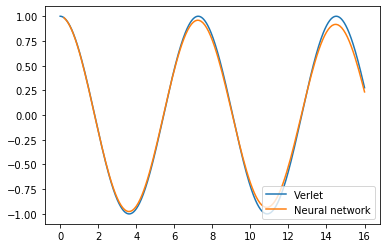

In [6]:
# Final time
T_final = 16

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 1.0
v[0] = 0.0
verlet_integrator.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet = []
x_verlet = []
while t<T_final:
    t_verlet.append(t)
    x_verlet.append(verlet_integrator.x[0])
    verlet_integrator.integrate(1)    
    t += dt_verlet
        

# ==== Neural network integrator ====

# Initialise with Verlet integrator
x_initial = np.zeros((nn_integrator.nsteps,nn_integrator.dynamical_system.dim))
v_initial = np.zeros((nn_integrator.nsteps,nn_integrator.dynamical_system.dim))
verlet_integrator.set_state(x,v)
for k in range(nn_integrator.nsteps):    
    x_initial[k,:] = verlet_integrator.x[:]
    v_initial[k,:] = verlet_integrator.v[:]
    verlet_integrator.integrate(int(dt/dt_verlet))
nn_integrator.set_state(x_initial,v_initial)
t = (nn_integrator.nsteps-1)*nn_integrator.dt

# Timestepping loop
t_nn = []
x_nn = []
while t<T_final:
    t_nn.append(t)
    x_nn.append(nn_integrator.x[0])
    nn_integrator.integrate(1)
    t += dt

# Plot all trajectories
plt.plot(t_verlet,x_verlet,label='Verlet')
plt.plot(t_nn,x_nn,label='Neural network')
plt.legend(loc='lower right')